In [96]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
from functools import partial
import json
import traceback
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt 
import pylab

import imlib as im
from imlib.dtype import *
import numpy as np
import pylib
import tensorflow as tf
import tflib as tl

import data
import models

import os
import time
from PIL import Image

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline


In [2]:
experiment_name = 128
with open('./output/%s/setting.txt' % experiment_name) as f:
    args = json.load(f)

# model
atts = args['atts']
n_att = len(atts)
img_size = args['img_size']
shortcut_layers = args['shortcut_layers']
inject_layers = args['inject_layers']
enc_dim = args['enc_dim']
dec_dim = args['dec_dim']
dis_dim = args['dis_dim']
dis_fc_dim = args['dis_fc_dim']
enc_layers = args['enc_layers']
dec_layers = args['dec_layers']
dis_layers = args['dis_layers']

label = args['label']
use_stu = args['use_stu']
stu_dim = args['stu_dim']
stu_layers = args['stu_layers']
stu_inject_layers = args['stu_inject_layers']
stu_kernel_size = args['stu_kernel_size']
stu_norm = args['stu_norm']
stu_state = args['stu_state']
multi_inputs = args['multi_inputs']
rec_loss_weight = args['rec_loss_weight']
one_more_conv = args['one_more_conv']

dataroot = './data/celeba/'

gpu = 'all'
if gpu != 'all':
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu

use_cropped_img = args['use_cropped_img']
thres_int = args['thres_int']

## change single attribution

Using selected images: [10]


/Users/qinshuo/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
(1, 128, 128, 3)
[[[[-0.9843137  -0.9529412  -0.92941177]
   [-0.9843137  -0.9529412  -0.92941177]
   [-0.9843137  -0.9529412  -0.92941177]
   ...
   [-0.8039216  -0.75686276 -0.6313726 ]
   [-0.8039216  -0.75686276 -0.6313726 ]
   [-0.8039216  -0.75686276 -0.6313726 ]]

  [[-0.9843137  -0.9529412  -0.92941177]
   [-0.9843137  -0.9529412  -0.92941177]
   [-0.9843137  -0.9529412  -0.92941177]
   ...
   [-0.80634654 -0.75928766 -0.6386473 ]
   [-0.80634654 -0.75928766 -0.6386473 ]
   [-0.80634654 -0.75928766 -0.6386473 ]]

  [[-0.9843137  -0.9529412  -0.92941177]
   [-0.9843137  -0.9529412  -0.92941177]
   [-0.9843137  -0.9529412  -0.92941177]
   ...
   [-0.8122208  -0.765162   -0.6562704 ]
   [-0.8122209  -0.76516205 -0.6562704 ]
   [-0.8122209  -0.765162   -0.6562704 ]]

  ...

  [[ 0.23154974  0.03465676 -0.1221084 ]
   [ 0.28990245  0.07724822 -0.0532847 ]
   [ 0.30575538  0.07

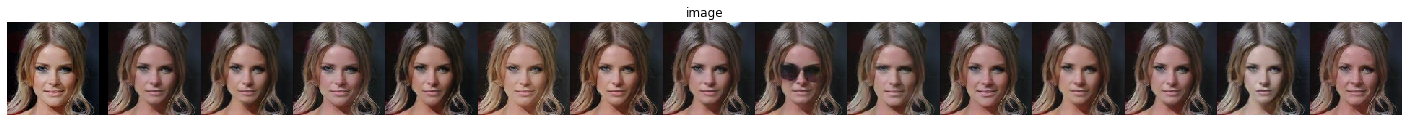

In [133]:
# change single attribution
# 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Male', 
# 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Young'

test_slides = False
img = [10]
test_int = 1.0
print('Using selected images:', img)

# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================

# data
sess = tl.session()
te_data = data.Celeba(dataroot, atts, img_size, 1, part='test', sess=sess, crop=not use_cropped_img, im_no=img)

# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)
    
# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)

for idx, batch in enumerate(te_data):
    xa_sample_ipt = batch[0]
    a_sample_ipt = batch[1]
    b_sample_ipt_list = [a_sample_ipt.copy() for _ in range(1)]
    print(xa_sample_ipt.shape)
    print(xa_sample_ipt)
    
    for i in range(len(atts)):
        tmp = np.array(a_sample_ipt, copy=True)
        # print('1:', tmp)
        tmp[:, i] = 1 - tmp[:, i]   # inverse attribute
        # print('2:', tmp)
        tmp = data.Celeba.check_attribute_conflict(tmp, atts[i], atts)
        # print('3:', tmp)
        b_sample_ipt_list.append(tmp)
        
    x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]
    raw_a_sample_ipt = a_sample_ipt.copy()
    raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
    
    for i, b_sample_ipt in enumerate(b_sample_ipt_list):
        _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
        if i > 0:
            _b_sample_ipt[..., i - 1] = _b_sample_ipt[..., i - 1] * test_int
        print(_b_sample_ipt)
        start_time = time.time()
        x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                               _b_sample: _b_sample_ipt,
                                                               raw_b_sample: raw_a_sample_ipt}))
        duration = time.time() - start_time
        print('duration of process No.{} attribution({}) of image {}.png is: {:.3f}s'.format(i,
                                                                                        'no-change' if i == 0 else atts[i - 1],
                                                                                        idx + 182638 if img is None else img[idx],
                                                                                        duration))
    sample = np.concatenate(x_sample_opt_list, 2)
    img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
    
    pylab.rcParams['figure.figsize'] = (25.0, 15.0)
    plt.imshow(img)
    plt.axis('off') 
    plt.title('image') 
    plt.show()
    img.show()

## change multiple attributions at the same time

Using selected images: [202559]


/Users/qinshuo/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
a_sample_ipt: [[0 1 0 0 1 0 0 0 1 0 1 0 0]]
b_sample_ipt_list: [array([[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0]])]
raw_a_sample_ipt: [[-0.5  0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5  0.5 -0.5  0.5 -0.5 -0.5]]
[[-0.5  0.5 -0.5 -0.5  0.5 -0.5 -0.5  1.   0.5 -0.5  0.5  0.5 -0.5]]
time cost:3.259s


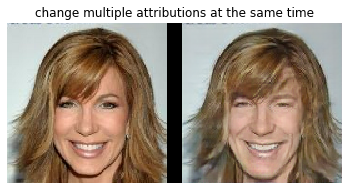

In [147]:
# change multiple attributions at the same time
# 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Male', 
# 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Young'

test_atts = ['Male', 'Pale_Skin']
test_intens = [2.0, 1.0]
img = [202559]
print('Using selected images:', img)

# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================

# data
sess = tl.session()
te_data = data.Celeba(dataroot, atts, img_size, 1, part='test', sess=sess, crop=not use_cropped_img, im_no=img)

# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)
    
# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)

for idx, batch in enumerate(te_data):
    xa_sample_ipt = batch[0]
    a_sample_ipt = batch[1]
    b_sample_ipt_list = [a_sample_ipt.copy()]
    print('a_sample_ipt:', a_sample_ipt)
    
    for index, a in enumerate(test_atts):
        i = atts.index(a)
        # overturn all attribution values in a_sample_ipt that appear in test_atts
        b_sample_ipt_list[-1][:, i] = 1 - b_sample_ipt_list[-1][:, i]
        b_sample_ipt_list[-1] = data.Celeba.check_attribute_conflict(b_sample_ipt_list[-1], atts[i], atts)
    print('b_sample_ipt_list:', b_sample_ipt_list)
    
    x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]
    
    # make raw_a_sample_ipt uniform distribution in [-1, 1]
    raw_a_sample_ipt = a_sample_ipt.copy()
    raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
    print('raw_a_sample_ipt:', raw_a_sample_ipt)
    
    # calculate the intensity value of _b_sample_ipt according to test_ints
    for i, b_sample_ipt in enumerate(b_sample_ipt_list):
        _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
        for t_att, t_int in zip(test_atts, test_intens):
            _b_sample_ipt[..., atts.index(t_att)] = _b_sample_ipt[..., atts.index(t_att)] * float(t_int)
        
        print(_b_sample_ipt)
        
        start_time = time.time()
        x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                               _b_sample: _b_sample_ipt,
                                                               raw_b_sample: raw_a_sample_ipt}))
        duration = time.time() - start_time
        print('time cost:{:.3f}s'.format(duration))
        
    sample = np.concatenate(x_sample_opt_list, 2)
    img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
    
    pylab.rcParams['figure.figsize'] = (6.0, 3.0)
    plt.imshow(img)
    plt.axis('off') 
    plt.title('change multiple attributions at the same time')
    plt.show()
    # img.show()

## change single attributions at the same time with attribute intensity control 

Using selected images: [182792]


/Users/qinshuo/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
[[-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.   0.  -1.   0.  -1.  -1.5]]
time cost:3.234s
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.          0.         -1.          0.         -1.
  -1.27777778]]
time cost:0.738s
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.          0.         -1.          0.         -1.
  -1.05555556]]
time cost:0.792s
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.          0.         -1.          0.         -1.
  -0.83333333]]
time cost:1.199s
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.          0.         -1.          0.         -1.
  -0.61111111]]
time cost:0.753s
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.          0.         -1.          0.         -1.
  -0.38888889]

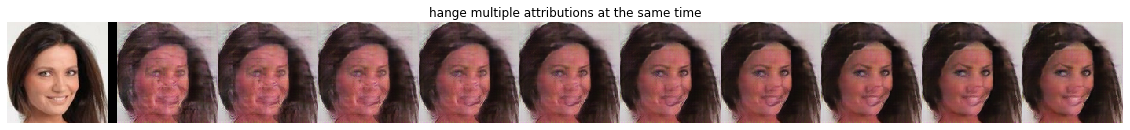

In [143]:
# change multiple attributions at the same time attribute intensity control 
# 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Male', 
# 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Young'

test_att = 'Young'
test_slide = True
test_int_min = -1.0
test_int_max = 1.0
n_slide = 10
img = [182792]
print('Using selected images:', img)
    
# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================

# data
sess = tl.session()
te_data = data.Celeba(dataroot, atts, img_size, 1, part='test', sess=sess, crop=not use_cropped_img, im_no=img)

# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)
    
# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)

for idx, batch in enumerate(te_data):
    xa_sample_ipt = batch[0]
    a_sample_ipt = batch[1]
    b_sample_ipt_list = [a_sample_ipt.copy() for _ in range(n_slide if test_slide else 1)]
    
    for i in range(n_slide):
        test_int = (test_int_max - test_int_min) / (n_slide - 1) * i + test_int_min
        b_sample_ipt_list[i] = (b_sample_ipt_list[i]*2-1) * thres_int
        b_sample_ipt_list[i][..., atts.index(test_att)] = test_int
    
    x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]
    raw_a_sample_ipt = a_sample_ipt.copy()
    raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
    
    for i, b_sample_ipt in enumerate(b_sample_ipt_list):
        _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
        print(_b_sample_ipt)
        start_time = time.time()
        x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                               _b_sample: _b_sample_ipt,
                                                               raw_b_sample: raw_a_sample_ipt}))
        duration = time.time() - start_time
        print('time cost:{:.3f}s'.format(duration))
    
    sample = np.concatenate(x_sample_opt_list, 2)
    img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
    
    pylab.rcParams['figure.figsize'] = (20.0, 10.0)
    plt.imshow(img)
    plt.axis('off') 
    plt.title('hange multiple attributions at the same time') 
    plt.show()
    img.show()

## single red image and single attribute test

In [126]:
# ==============================================================================
# =                                   graphs                                   =
# ==============================================================================
# models
Genc = partial(models.Genc, dim=enc_dim, n_layers=enc_layers, multi_inputs=multi_inputs)
Gdec = partial(models.Gdec, dim=dec_dim, n_layers=dec_layers, shortcut_layers=shortcut_layers,
               inject_layers=inject_layers, one_more_conv=one_more_conv)
Gstu = partial(models.Gstu, dim=stu_dim, n_layers=stu_layers, inject_layers=stu_inject_layers,
               kernel_size=stu_kernel_size, norm=stu_norm, pass_state=stu_state)

# inputs
xa_sample = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])
raw_b_sample = tf.placeholder(tf.float32, shape=[None, n_att])

# sample
test_label = _b_sample - raw_b_sample if label == 'diff' else _b_sample
if use_stu:
    x_sample = Gdec(Gstu(Genc(xa_sample, is_training=False),
                         test_label, is_training=False), test_label, is_training=False)
else:
    x_sample = Gdec(Genc(xa_sample, is_training=False), test_label, is_training=False)

/Users/qinshuo/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 [*] Loading checkpoint succeeds! Copy variables from ./output/128/checkpoints/Epoch_(139)_(947of947).ckpt!
a_sample_ipt: [[0 0 1 0 0 1 0 0 0 0 1 0 1]]
b_sample_ipt_list: [array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])]
raw_a_sample_ipt: [[-0.5 -0.5  0.5 -0.5 -0.5  0.5 -0.5 -0.5 -0.5 -0.5  0.5 -0.5  0.5]]
[[-0.5 -0.5  0.5 -0.5 -0.5 -1.  -0.5 -0.5 -0.5 -0.5 -1.  -0.5  0.5]]
time cost:3.476s


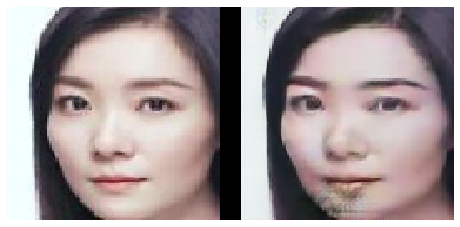

In [129]:
# change multiple attributions at the same time attribute intensity control 
# 'Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Eyeglasses', 'Male', 
# 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Young'

img_name = './data/red/2478.jpg'
label = np.array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,]])
test_atts = ['No_Beard', 'Bushy_Eyebrows']
test_intens = [2.0, 2.0]
result_folder = './red_result/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# data
sess = tl.session()
img = Image.open(img_name)
img = np.array(img.resize((img_size, img_size))) / 127.5 - 1
img = np.expand_dims(img, 0)


    
# ==============================================================================
# =                                    test                                    =
# ==============================================================================

# initialization
ckpt_dir = './output/%s/checkpoints' % experiment_name
tl.load_checkpoint(ckpt_dir, sess)
multi_atts = test_atts is not None
idx = 0
batch = (img, label)
xa_sample_ipt = batch[0]
a_sample_ipt = batch[1]
b_sample_ipt_list = [a_sample_ipt.copy()]
print('a_sample_ipt:', a_sample_ipt)

for index, a in enumerate(test_atts):
    i = atts.index(a)
    # overturn all attribution values in a_sample_ipt that appear in test_atts
    b_sample_ipt_list[-1][:, i] = 1 - b_sample_ipt_list[-1][:, i]
    b_sample_ipt_list[-1] = data.Celeba.check_attribute_conflict(b_sample_ipt_list[-1], atts[i], atts)
print('b_sample_ipt_list:', b_sample_ipt_list)

x_sample_opt_list = [xa_sample_ipt, np.full((1, img_size, img_size // 10, 3), -1.0)]

# make raw_a_sample_ipt uniform distribution in [-1, 1]
raw_a_sample_ipt = a_sample_ipt.copy()
raw_a_sample_ipt = (raw_a_sample_ipt * 2 - 1) * thres_int
print('raw_a_sample_ipt:', raw_a_sample_ipt)

# calculate the intensity value of _b_sample_ipt according to test_ints
for i, b_sample_ipt in enumerate(b_sample_ipt_list):
    _b_sample_ipt = (b_sample_ipt * 2 - 1) * thres_int
    for t_att, t_int in zip(test_atts, test_intens):
        _b_sample_ipt[..., atts.index(t_att)] = _b_sample_ipt[..., atts.index(t_att)] * float(t_int)

    print(_b_sample_ipt)

    start_time = time.time()
    x_sample_opt_list.append(sess.run(x_sample, feed_dict={xa_sample: xa_sample_ipt,
                                                           _b_sample: _b_sample_ipt,
                                                           raw_b_sample: raw_a_sample_ipt}))
    duration = time.time() - start_time
    print('time cost:{:.3f}s'.format(duration))

sample = np.concatenate(x_sample_opt_list, 2)
img = Image.fromarray(to_range(sample.squeeze(0), 0, 255, np.uint8))
img.save(os.path.join(result_folder, img_name.split('/')[-1]))

pylab.rcParams['figure.figsize'] = (8.0, 4.0)
plt.imshow(img)
plt.axis('off')
plt.show()
# img.show()